## Automated model defintion for variable global and local parameters
The overall goal of this structure is to have one top-level model which can be fed with the parameters relevant for a dataset. The model then passes the parameters necessary for the fitting of the individual experiments to models on the lower levels. Those calculate the scalar of the loss functions and the sum of all the loss functions is returned to the high-level model which then performs the optimization step.

### Importing packages

In [1]:
%load_ext autoreload
%autoreload 2

import logging
logger = logging.getLogger(__name__)
import matplotlib.cm
from matplotlib import pyplot
import numpy
import pandas
import pathlib
import scipy.optimize
import bletl

import calibr8
import murefi

### Create a dataset object from biolector data

In [2]:
filepath = pathlib.Path('Data', 'SiLA_Coryne_Standard_20181026_150350.csv')

bldata = bletl.parse(filepath) #dictionary with FilterTimeSeries objects

C:\Users\zufal\Miniconda3\envs\murefi-dev\lib\site-packages\bletl\parsing\bl1.py:113: UserWarning: Calibration values for DO signal are missing. Skipping calibration.
  warnings.warn('Calibration values for DO signal are missing. Skipping calibration.')
C:\Users\zufal\Miniconda3\envs\murefi-dev\lib\site-packages\bletl\parsing\bl1.py:104: UserWarning: Calibration values for pH signal are missing. Skipping calibration.
  warnings.warn('Calibration values for pH signal are missing. Skipping calibration.')


#### The parameter file determines the wells included in the dataset and fit
Here, only wells A2, A3, B1, B2 and B3 all having the same parameters are extracted from the data

In [3]:
parameter_path = pathlib.Path('Data', 'Parametertest.csv')

In [4]:
df_mapping = pandas.read_csv(parameter_path, sep=';').iloc[2:]
df_mapping

,Parameter,S_0,X_0,mue_max,K_S,Y_XS
2,A02,S_0,X_0,mue_max,K_S,Y_XS
3,A03,S_0,X_0,mue_max,K_S,Y_XS
4,B01,S_0,X_0,mue_max,K_S,Y_XS
5,B02,S_0,X_0,mue_max,K_S,Y_XS
6,B03,S_0,X_0,mue_max,K_S,Y_XS


In [5]:
model = murefi.MonodModel()
model.bounds = dict(
    S_0=(0,20),
    X_0=(0,1),
    mue_max=(0,0.8),
    K_S=(0,0.2),
    Y_XS=(0,0.8)
)
model.guesses = dict(
    S_0=10,
    X_0=0.2,
    mue_max=0.3,
    K_S=0.05,
    Y_XS=(0.5)
)

In [6]:
mapping = murefi.ParameterMapping(df_mapping, bounds = model.bounds, guesses = model.guesses)

mapping.mapping

{'A02': ('S_0', 'X_0', 'mue_max', 'K_S', 'Y_XS'),
 'A03': ('S_0', 'X_0', 'mue_max', 'K_S', 'Y_XS'),
 'B01': ('S_0', 'X_0', 'mue_max', 'K_S', 'Y_XS'),
 'B02': ('S_0', 'X_0', 'mue_max', 'K_S', 'Y_XS'),
 'B03': ('S_0', 'X_0', 'mue_max', 'K_S', 'Y_XS')}

In [7]:
dependent_key = 'BS10'

def create_dataset_object(bldata:bletl.BLData, parameter_mapping):
    """Function to create a dataset object for all replicates
    Args:
        bldata:     dictionary with 'FilterTimeSeries' objects (technicially 
                        calibrated data) from bletl (bldata.calibrated_data)
        par_dic:        dictionary containing well IDs as keys and the
                        parameters for fitting provided by the user
                        (murefi.ParameterMapping(parameter_path).parameters_dic)
    Returns:
        dataset (murefi.Dataset): Replicate objects for each well
    """
    if not len(bldata[dependent_key].value.keys()) == len(parameter_mapping.mapping.keys()):
        excluded = [
            key
            for key in bldata[dependent_key].value.keys()
            if not key in parameter_mapping.mapping.keys()
        ]
        logger.warning(f'Not all measurements from {bldata} are converted to a Dataset object. Wells {excluded} were omitted.')
    dataset = murefi.Dataset()
    for well_id in parameter_mapping.mapping.keys():
        bs_x = bldata['BS10'].time[well_id][0:120]
        bs_y = bldata['BS10'].value[well_id].multiply(0.1187).add(0.5866)[0:120]
        bs_ts = murefi.Timeseries(list(bs_x), list(bs_y), independent_key='X', dependent_key=dependent_key)
        rep = murefi.Replicate(well_id)
        rep[dependent_key] = bs_ts
        dataset[well_id] = rep
    return dataset

    
dataset = create_dataset_object(bldata, mapping)
dataset

Not all measurements from {'BS10': <bletl.core.FilterTimeSeries object at 0x0000029D5FA5FBA8>} are converted to a Dataset object. Wells ['A01', 'A04', 'A05', 'A06', 'A07', 'A08', 'B04', 'B05', 'B06', 'B07', 'B08', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08'] were omitted.


Dataset([('A02', Replicate(BS10[:120])),
         ('A03', Replicate(BS10[:120])),
         ('B01', Replicate(BS10[:120])),
         ('B02', Replicate(BS10[:120])),
         ('B03', Replicate(BS10[:120]))])

### Function to calculate the loglikelihood of the dataset

## A fitting example

In [8]:
objective = murefi.objectives.for_dataset(dataset, model, mapping, error_models=[])
fit = scipy.optimize.minimize(objective, mapping.guesses, bounds=mapping.bounds)

In [9]:
result = pandas.DataFrame(columns=['parameters', 'estimate'])
result['parameters'] = mapping.parameters
result['estimate'] = fit.x
result

,parameters,estimate
K_S,K_S,0.05
S_0,S_0,10.00
X_0,X_0,0.20
Y_XS,Y_XS,0.50
mue_max,mue_max,0.30


### Plotting
Plot the 5 replicates and the fit

In [10]:
mapping.order

('S_0', 'X_0', 'mue_max', 'K_S', 'Y_XS')

In [11]:
mapping.mapping

{'A02': ('S_0', 'X_0', 'mue_max', 'K_S', 'Y_XS'),
 'A03': ('S_0', 'X_0', 'mue_max', 'K_S', 'Y_XS'),
 'B01': ('S_0', 'X_0', 'mue_max', 'K_S', 'Y_XS'),
 'B02': ('S_0', 'X_0', 'mue_max', 'K_S', 'Y_XS'),
 'B03': ('S_0', 'X_0', 'mue_max', 'K_S', 'Y_XS')}

In [12]:
mapping.parameters

OrderedDict([('K_S', 'K_S'),
             ('S_0', 'S_0'),
             ('X_0', 'X_0'),
             ('Y_XS', 'Y_XS'),
             ('mue_max', 'mue_max')])

In [13]:
mapping.guesses

(0.05, 10, 0.2, 0.5, 0.3)

In [14]:
fit.x

array([ 0.05, 10.  ,  0.2 ,  0.5 ,  0.3 ])

In [15]:
mapping.repmap(fit.x)

{'A02': array([10.  ,  0.2 ,  0.3 ,  0.05,  0.5 ]),
 'A03': array([10.  ,  0.2 ,  0.3 ,  0.05,  0.5 ]),
 'B01': array([10.  ,  0.2 ,  0.3 ,  0.05,  0.5 ]),
 'B02': array([10.  ,  0.2 ,  0.3 ,  0.05,  0.5 ]),
 'B03': array([10.  ,  0.2 ,  0.3 ,  0.05,  0.5 ])}

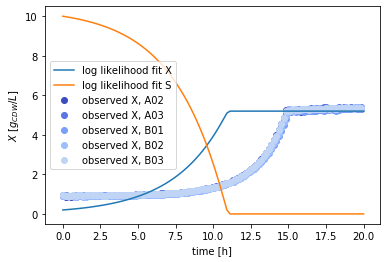

In [16]:
theta_dict = mapping.repmap(fit.x)

# High-resolution template for the prediction
template = murefi.Replicate.make_template(0, 20, ['S', 'X'])

# Make a prediction for a well of interest
well = 'A02'
y_pred = model.predict_replicate(theta_dict[well], template)

#Plot replicates
pyplot.figure()
steps = numpy.arange(0, 1, 0.1).tolist()
cmap = pyplot.cm.coolwarm
for i, well in enumerate(dataset.keys()):
    pyplot.scatter(
        dataset[well][dependent_key].x,
        dataset[well][dependent_key].y,
        label=f'observed X, {well}',
        color=cmap(steps[i])
    )

#Plot fit
for yk in {'S', 'X'}:
    pyplot.plot(y_pred[yk].x, y_pred[yk].y, label=f'log likelihood fit {yk}')

pyplot.xlabel('time [h]')
pyplot.ylabel('$X\ [g_{CDW}/L]$')
pyplot.legend()
pyplot.show()

The optimization did not actually fit anything, because we did not specify an error model when creating the objective!